In [1]:
import torch
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
library_path = '/Users/salvatoreesposito/Desktop/peakonly'
sys.path.append(library_path)
from models.rcnn import RecurrentCNN
from models.cnn_classifier import Classifier
from models.cnn_segmentator import Segmentator
from processing_utils.roi import ROI

%load_ext autoreload
%autoreload 2

In [2]:
# checking if gpu is available

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


In [3]:
# importing the pre-trained RNN  and loading weights
# the RNN is defined
model = RecurrentCNN().to(device)
path2weights = os.path.join(library_path,'data', 'weights', 'RecurrentCNN.pt')
model.load_state_dict(torch.load(path2weights, map_location=device))
model.eval()

RecurrentCNN(
  (encoding): EncodingCNN(
    (encoding): Sequential(
      (0): Conv1d(2, 16, kernel_size=(5,), stride=(1,), padding=(2,))
      (1): ReLU()
      (2): Conv1d(16, 32, kernel_size=(5,), stride=(1,), padding=(2,))
      (3): ReLU()
      (4): Conv1d(32, 64, kernel_size=(5,), stride=(1,), padding=(2,))
      (5): ReLU()
    )
  )
  (biLSTM): LSTM(64, 64, batch_first=True, bidirectional=True)
  (LSTM): LSTM(128, 128, batch_first=True)
  (classifier): Linear(in_features=128, out_features=2, bias=True)
  (integrator): Linear(in_features=128, out_features=2, bias=True)
)

In [4]:
mzml_filepath = "/Users/salvatoreesposito/Downloads/peakonly-master/data/annotation/Dataset"

In [5]:
import json
import time
import sys
from Main import peakonly
from os import listdir
from os.path import isfile, join, isdir
start = time.time()
# firstly we access the directory to look for the file path
directories = [f for f in listdir(mzml_filepath) if isdir(join(mzml_filepath, f))]
for dir in directories:
    dir = mzml_filepath + "/" + dir
    onlyfiles = [f for f in listdir(dir) if isfile(join(dir, f))]
    rois = []
    for files in onlyfiles:
            # open files in the directory which are json files
        with open(dir + "/" + files) as json_file:
            try:
                data = json.load(json_file)
            except: 
                continue
            num_peaks = data["number of peaks"]
         # get only the files where the number of peaks is = 1
        if num_peaks == 1:
            rois += peakonly(onlyfiles)

end = time.time()
print(end - start)



4.2685840129852295


In [6]:
from processing_utils.run_utils import preprocess, correct_classification, get_borders, Feature
from Main import sub_rois
import time
from roi import ROI as poROI
import csv
start = time.time()
split_rois=[]
# `Look at comments in the Classifier 
for idx, roi in enumerate(rois):
    if roi.peak_list[-1].scan - roi.peak_list[0].scan >= 5:
        with open("Results_rnn/RNN_roi_" + str (idx) + ".csv", 'w') as file:
            percentage = 10
            split_rois = sub_rois(roi,percentage)
            file.write("percentage,result,mz,rt,scan,max_intensity" + "\n")
            for i in range(len(split_rois)-1):
                rr = poROI([split_rois[i].peak_list[0].scan,split_rois[i].peak_list[-1].scan],
                        [split_rois[i].peak_list[0].rt,split_rois[i].peak_list[-1].rt],
                        [p.i for p in split_rois[i].peak_list],
                        [split_rois[i].peak_list[0].mz,split_rois[i].peak_list[-1].mz],split_rois[i].mean_mz)
                        # RNN does not interpolate signal
                signal = preprocess(rr.i, torch.device('cpu'))
                classifier_output, segmentator_output = model(signal)
                classifier_output = classifier_output.data.cpu().numpy()
                segmentator_output = segmentator_output.data.sigmoid().cpu().numpy()
                # borders are defined as the start and end of a peak in the segmentator 
                borders = get_borders(segmentator_output[0, 0, :], segmentator_output[0, 1, :],
                peak_minimum_points=8)
                # label is the output of the RNN
                label = np.argmax(classifier_output)
                label = result
                if result > 0.5:
                    result = 1
                else: 
                    result = 0
                features = []
                # create feature objects for peak integration 
                for border in borders:
                    # to do: check correctness of rt calculations
                    scan_frequency = (rr.scan[1] - rr.scan[0]) / (rr.rt[1] - rr.rt[0])
                    rtmin = rr.rt[0] + border[0] / scan_frequency
                    rtmax = rr.rt[0] + border[1] / scan_frequency
                    feature = Feature(["AAA"], [roi], [border], [0], [np.sum(rr.i[border[0]:border[1]])],
                                    rr.mzmean, rtmin, rtmax, 0, 0)
                    features.append(feature)
                    
                    label = np.argmax(classifier_output)
                    result = label
                    
                file.write(str(i*percentage + percentage) + " ," + str(result)+ " ," + str(np.array(rr.mz))+ " ," + str(np.array(rr.rt))                    + " ," + str(np.array(rr.scan)) + " ," + str(np.max(rr.i)) + "\n")


        
end = time.time()
print(end - start)
    

218.6248562335968


In [10]:
from os import listdir
import statistics
from os.path import isfile, join, isdir
import numpy as np
import csv
import pandas as pd
onlyfiles = [f for f in listdir("Results_rnn") if isfile(join("Results_rnn", f))]
rois = []
percentages = []
intensities = []
mz = []
rt = []
rnn_percentage = []
num_rois = 0
num_classified_rois = 0
# Check comments in the Classifier as is almost the same method
for files in onlyfiles:
    findpercentage = False
    file_name = files
    with open("Results_rnn/"+files, 'r') as file:
        next(file)
        for line in file:
            line = line.split(",")
            if line[1].strip()== str (1):
                percentage = line[0].strip()
                result = line[1].strip()
                if (int(result)) == 1 and not findpercentage:
                    rnn_percentage.append(int(percentage))
                    findpercentage = True
                intensity = line[5].strip()
                percentages.append(line[0])
                mzstart = line[2].split()[0]
                mzend = line[2].split()[1]
                mzstart = mzstart.replace("[","")
                mzend= mzend.replace("]","")
                mzvalue = statistics.mean([float(mzstart), float(mzend)])
                mz.append(mzvalue)
                rt_start = line[3].split()[0]
                rt_end = line[3].split()[1]
                rt_start = rt_start.replace("[","")
                rt_end= rt_end.replace("]","")
                rtvalue = statistics.mean([float(rt_start), float(rt_end)])
                rt.append(rtvalue)
                num_classified_rois += 1
                intensity = float(intensity.replace("\n",""))
                intensities.append(intensity)
            num_rois += 1
        # calculate the mean of these values
            
mean_mz = statistics.mean(mz)
mean_rt = statistics.mean(rt)
intensity = statistics.mean(intensities)
percent = statistics.mean(rnn_percentage)

with open('Final_mean_rnn_results.csv', 'w', newline='') as csvfile: 
    meanwriter = csv.writer(csvfile, delimiter=' ',quotechar='|',quoting=csv.QUOTE_MINIMAL)
    meanwriter.writerow(["cnn_value_count","classified_rois","mean_mz","mean_rt","mean_max_intensity"])
    meanwriter.writerow([pd.Series(rnn_percentage).value_counts(),str(num_classified_rois/num_rois),mean_mz,mean_rt, intensity])

bar_data = pd.Series(rnn_percentage).value_counts()


0
60     87
50     82
40     73
90     69
30     62
70     59
20     47
80     43
10     33
100    23
0       0
dtype: int64


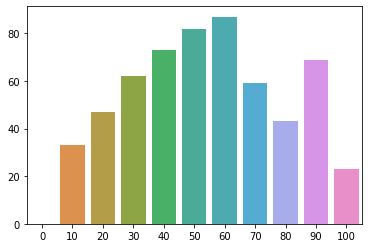

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

for i in range(0,101,10):
    if i not in bar_data.index:
        print(i)
        bar_data.at[i]=0
print(bar_data)
sns.barplot(x=bar_data.index, y= bar_data.values)